# Semi-Supervised VAE Project

In [1]:
%%bash
if [ -d VAEGen ]; then rm -rf VAEGen; fi
git clone https://github.com/BenjaminEriksen95/VAEGen.git # clone repo
cp VAEGen/code/*.py . # move python files into scope

Cloning into 'VAEGen'...


### Imports

In [26]:
from plotting import plot_64, plot_64_m2, plot_loss_m1, plot_loss_m2, plot_interpolation_m1, plot_interpolation_m2, make_cm
from models import VAE, M1, M2
from training import run_epochs
from datasets import importMNIST, importFashionMNIST
from loaders import stratified_sampler, create_loader, create_subset, get_target_indexes
from classifiers import kneighbors_classifier, linearregression_classifier, mlp_classifier
import torch

In [3]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from torch.utils.data import DataLoader, Subset
from torch.utils.data.sampler import SubsetRandomSampler

## Meta settings and init values

In [4]:
# Baseline meta settings
dataset="mnist" #("mnist"/"fashion")
batch_size = 512
epochs = 15
latent_dim = 8
learning_rate = 1e-3
image_channels = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classes = [0,1,2,3,4,5,6,7,8,9]
num_classes = len(classes)

# Initial Values
model = None
dset_train = None
dset_test = None
train_loss = []
train_acc = []
test_loss = []
test_acc = []


In [5]:
## Importing Dataset
if dataset=="mnist":
    dset_train, dset_test = importMNIST()
elif dataset=="fashion":
    dset_train, dset_test = importFashionMNIST()

## Creating Loaders
train_loader = create_loader(dset_train,batch_size)
test_loader = create_loader(dset_test,batch_size)    

## Load Datasets


### 2.1.4 (Report)
Plot 64 randomly chosen binarized MNIST samples on a 8 × 8 grid

Plotting non-binarized


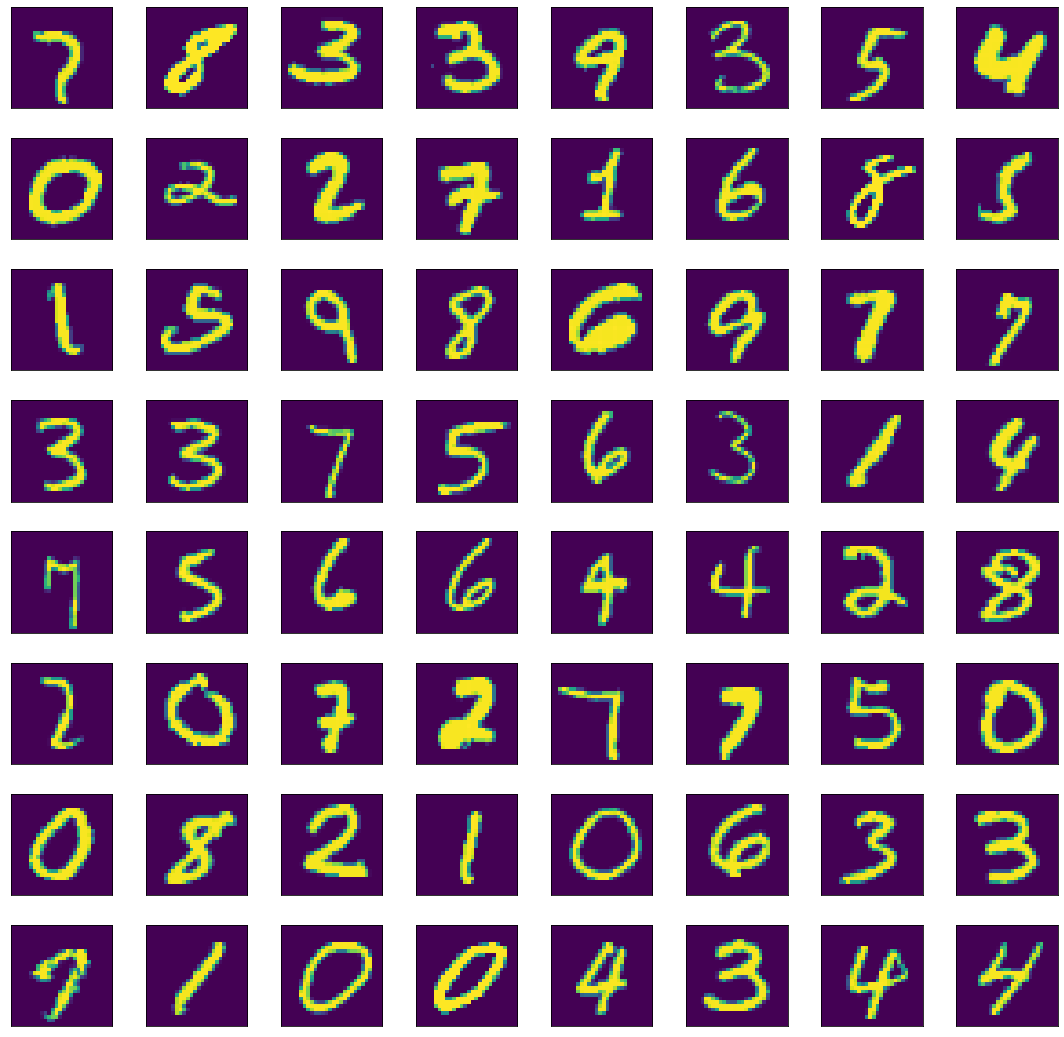

Plotting binarized


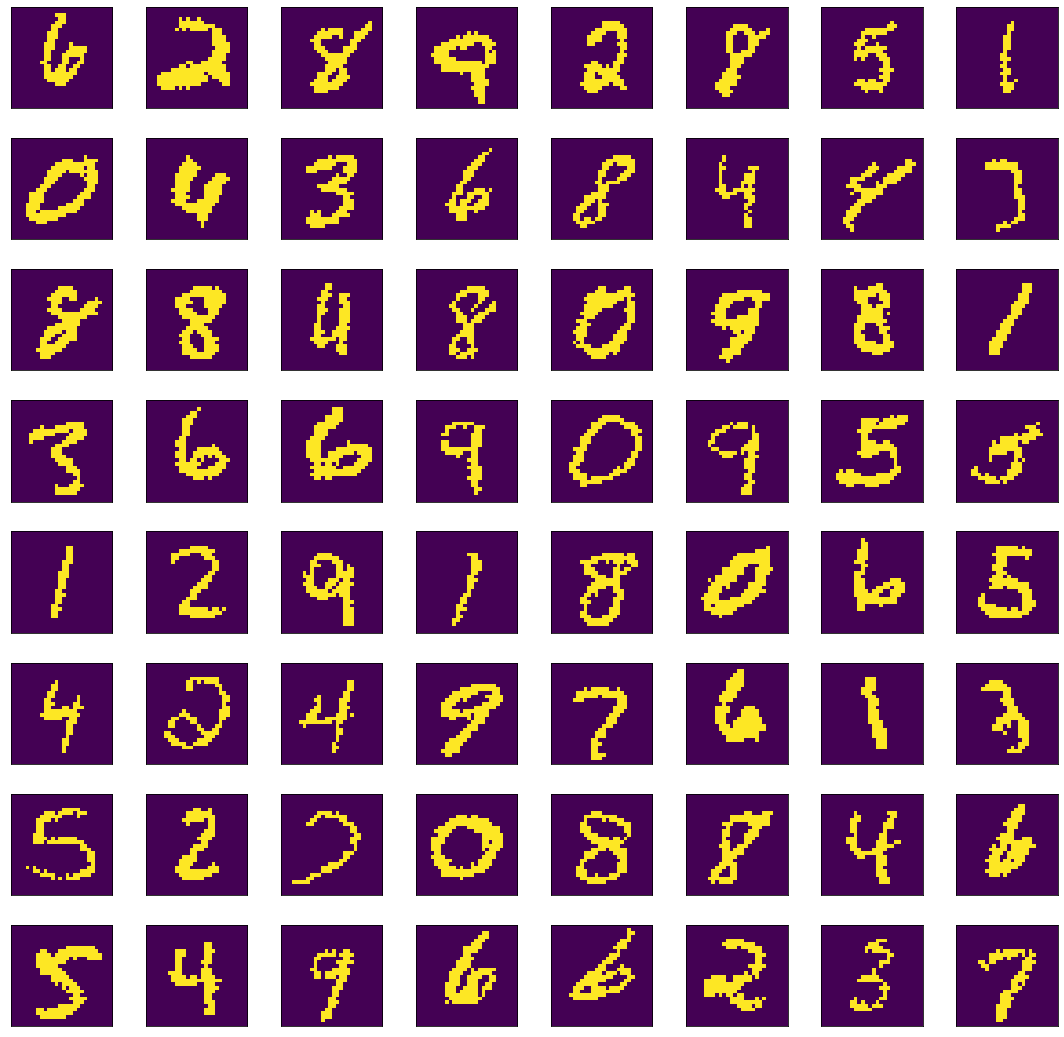

In [6]:
examples = enumerate(train_loader)

# Plot non-binarized
print("Plotting non-binarized")
plot_64(batch=examples)

dset_bin=None

if dataset=="mnist":
    dset_bin, dset_bin_test = importMNIST(binarized=True)
    
if dataset=="fashion":
    dset_bin, dset_bin_test = importFashionMNIST(binarized=True)

bin_loader = create_loader(dset_bin,batch_size)

examples = enumerate(bin_loader)
    
print("Plotting binarized")
plot_64(batch=examples)

## VAE

In [7]:
# define model and optimizer
mode = "vae"
model = VAE(device, image_channels=image_channels,h_dim=1024,z_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### 2.2.1.2 (Report) 
Generate 64 samples from the untrained model and plot them on a 8 × 8 grid.

Sampling before training


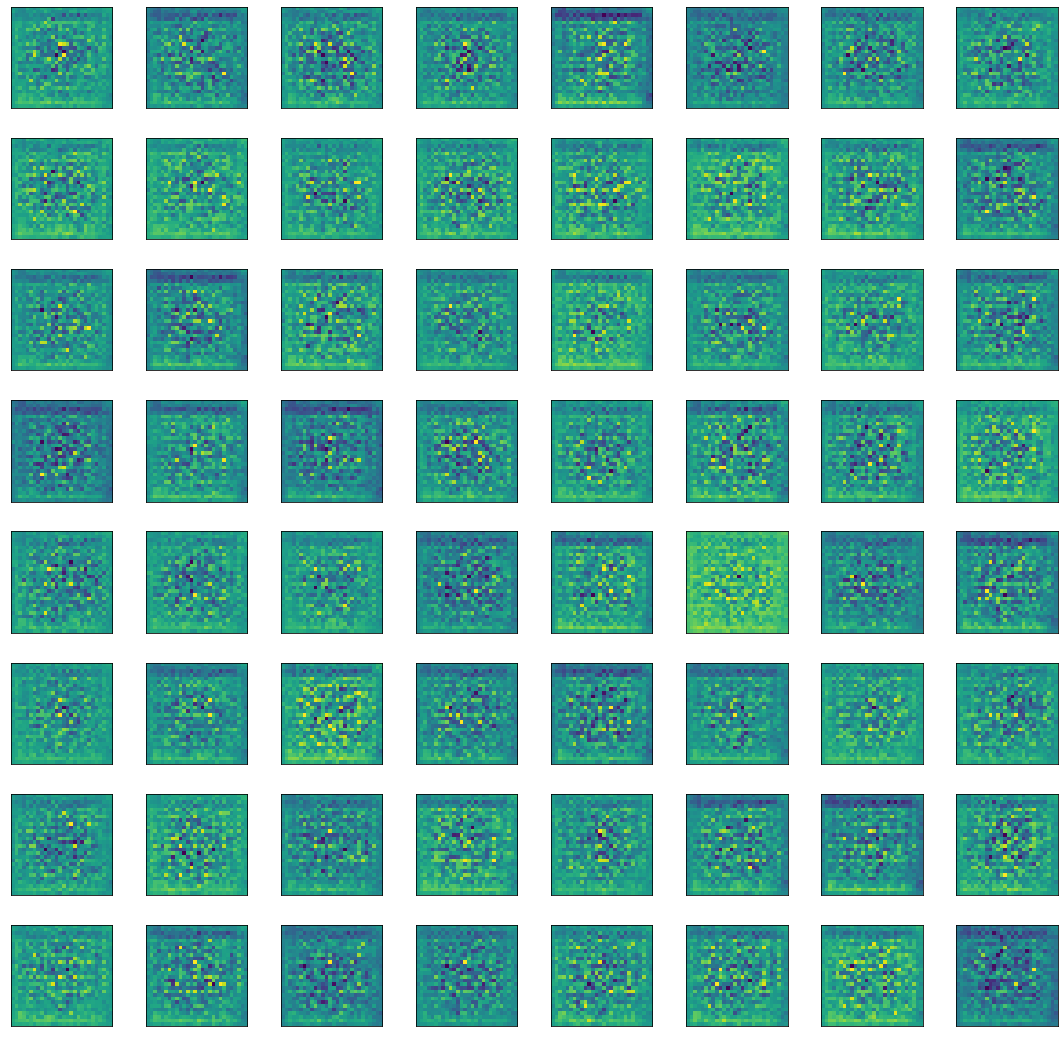

In [8]:
# Sample before training
print("Sampling before training")
plot_64(model=model, sample=True)

### 2.2.1.3 (Report)
Compute the ELBO of 64 samples from the training set using the untrained model and report the number.

In [9]:
loader_train = create_loader(dset_bin,batch_size)
examples = enumerate(loader_train)

idx, (samples, targets) = next(examples)
model.eval()
x_recon, mu, logvar = model.forward(samples.to(model.device), [])
elbo, bce, kld = model.loss_fn(x_recon, samples, mu, logvar)
print(f"ELBO: {elbo}")

ELBO: 268493.5625


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [10]:
epochs = 2

# Train network
run_epochs(mode, model, optimizer, epochs, train_loader, test_loader)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/2] Loss: 29.458 29.443 0.016
Epoch[2/2] Loss: 20.106 20.089 0.017


### 2.2.2.4 (Report) 
Generate 64 samples from the trained model and plot them on a 8 × 8 grid.

Sampling after training


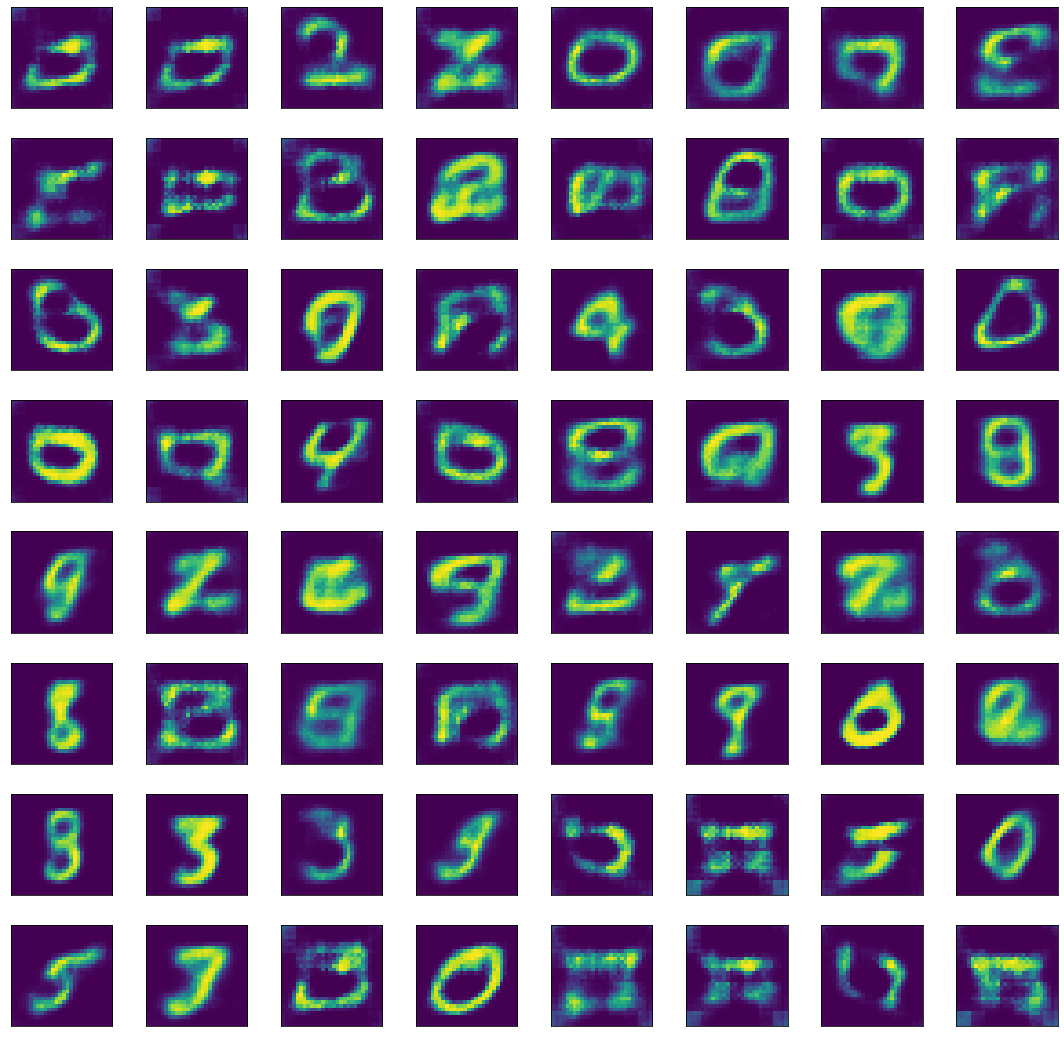

In [11]:
# Sample after training
print("Sampling after training")
plot_64(model=model, sample=True)

### 2.2.2.5 (Report)
Evaluate the trained model on the test set and report the number.

In [12]:
loader_test = create_loader(dset_bin_test,batch_size)
examples = enumerate(loader_test)

batch_idx, (example_data, example_targets) = next(examples)

model.eval()
recon_images, mu, logvar = model(example_data.to(device),example_targets)
loss, bce, kld = model.loss_fn(recon_images, example_data, mu, logvar)
to_print = "Loss – ELBO: {:.3f}, BCE: {:.3f}, KLD: {:.3f}".format(loss.data.cpu().numpy().tolist()/batch_size, bce.data.cpu().numpy().tolist()/batch_size, kld.data.cpu().numpy().tolist()/batch_size)
print(to_print)

Loss – ELBO: 102.251, BCE: 102.234, KLD: 0.017


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


## M1

In [13]:
epochs = 2
train_loss = []
train_acc = []
test_loss = []
test_acc = []


Epoch 1 of 2
	 Training ...


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


	 Testing ...
Train ELBO: -218.5055
Val ELBO: -169.9224
Epoch 2 of 2
	 Training ...
	 Testing ...
Train ELBO: -137.5765
Val ELBO: -112.4137


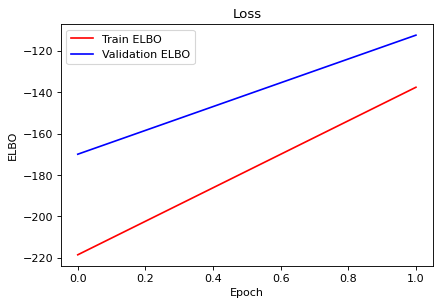

In [14]:
# define model and optimizer
mode = "m1"
model = M1(device, image_channels=1, h_dim=1024, z_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train network
train_loss, test_loss = run_epochs(mode, model, optimizer, epochs, train_loader, test_loader, train_loss, test_loss)

# plot loss
plot_loss_m1(train_loss,test_loss)


### 2.3.2 (Report)
Train a classifier on their latent representation. First try a linear classifier and then
experiment with other types of classifiers. Report the accuracies.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Mean acc (train):  0.97
Mean acc (test):  0.5910845588235294


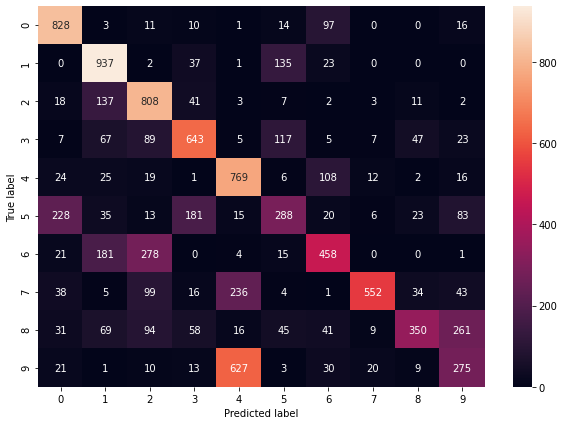

In [15]:
linearregression_classifier(model, dset_train, dset_test, classes)

Mean acc (train):  0.88
Mean acc (test):  0.09736328125


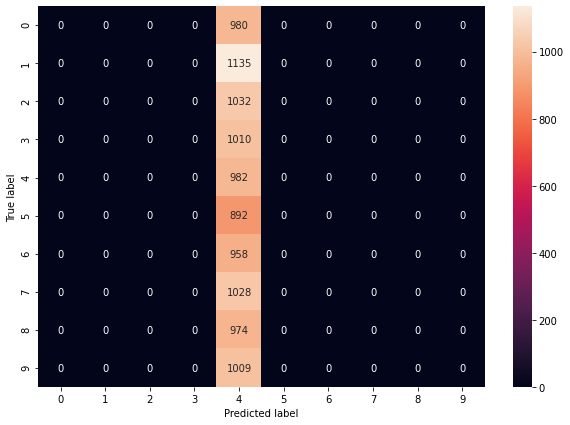

In [16]:
kneighbors_classifier(model, dset_train, dset_test, classes)

Mean acc (train):  1.0
Mean acc (test):  0.5996610753676471


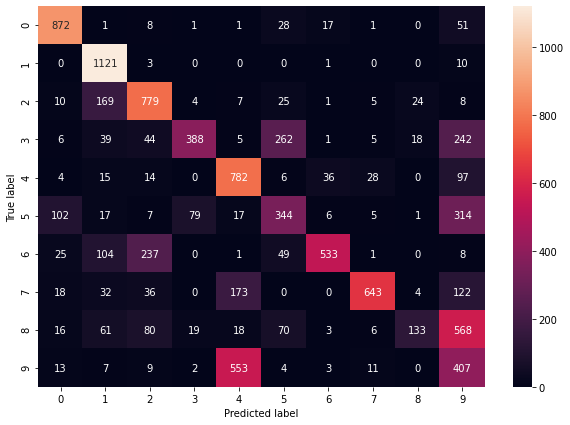

In [17]:
mlp_classifier(model, dset_train, dset_test, classes)

### 2.3.3 (Report)
Implement some simple baselines: Train a linear classifier or neural network from
scratch using *only* the 100 labeled data points. Report the accuracies.

Mean acc (train):  1.0
Mean acc (test):  0.6722081801470587


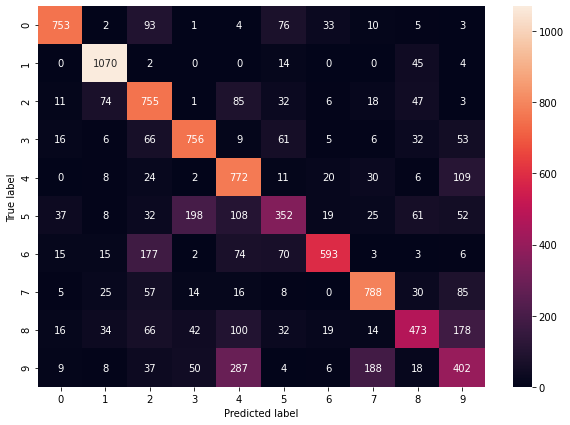

In [18]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

# training
idx_train_subset = get_target_indexes(dset_train, classes, 10)
X_train = dset_train.data[idx_train_subset]
# insert extra dim for the image channel
X_train = torch.flatten(X_train, start_dim=1).numpy()
y_train = dset_train.targets[idx_train_subset].numpy()

clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)
train_acc = sklearn.metrics.accuracy_score(y_train, y_pred)
print("Mean acc (train): ", train_acc)

# testing
loader_test = create_loader(dset_bin_test, batch_size)

test_acc_running = 0.
cm = np.zeros(shape=(len(classes), len(classes)), dtype=np.int16)


for idx, (images, labels) in enumerate(loader_test):
    X_test = torch.flatten(images, start_dim=1).numpy()
    y_test = labels.numpy()

    y_pred = clf.predict(X_test)
    test_acc_batch = sklearn.metrics.accuracy_score(y_test, y_pred)
    test_acc_running += test_acc_batch

    cm_batch = sklearn.metrics.confusion_matrix(
        y_true=y_test, y_pred=y_pred)
    cm += cm_batch

test_acc = test_acc_running / len(loader_test)
print("Mean acc (test): ", test_acc)

df_cm = pd.DataFrame(cm, index=[str(i) for i in classes],
                      columns=[str(i) for i in classes])

plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='d')
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

### Reconstructions and Interpolations

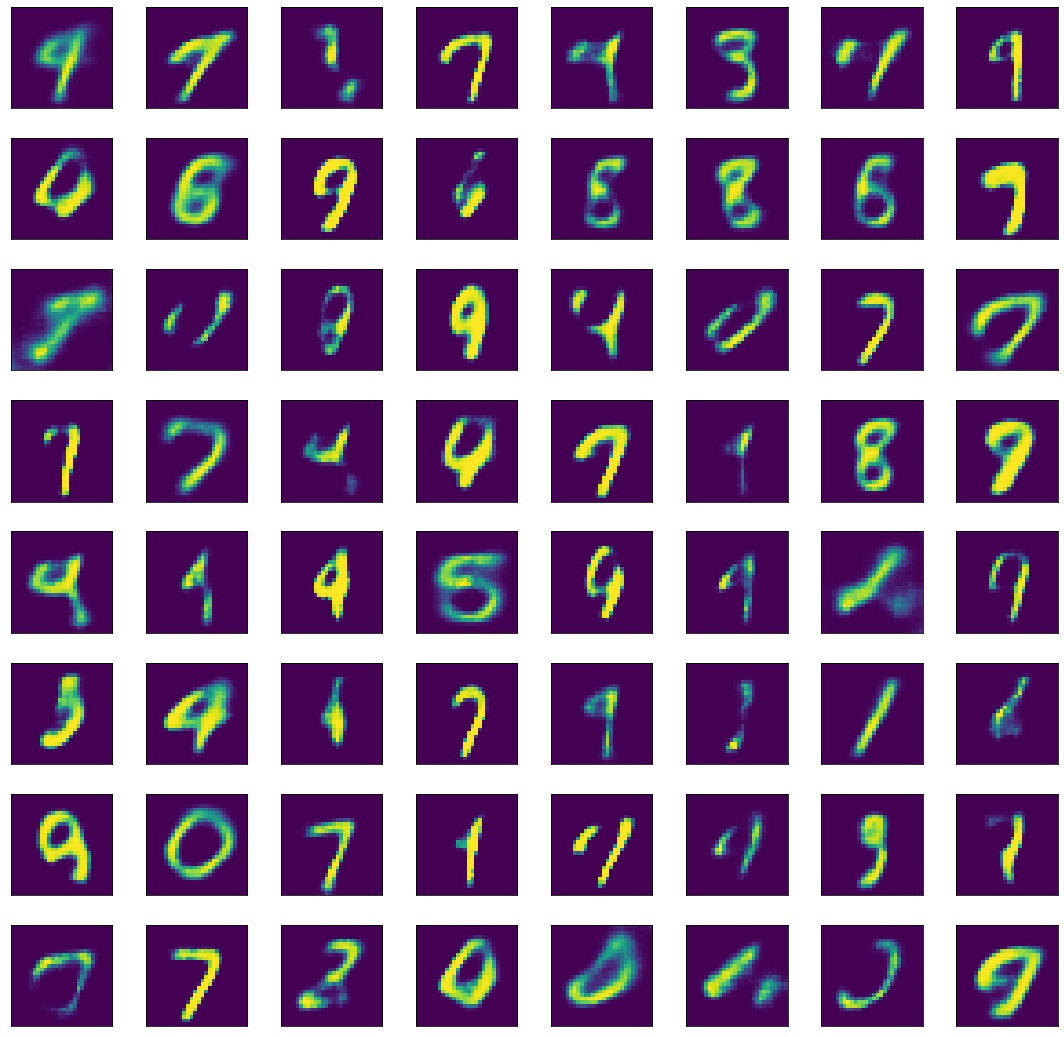

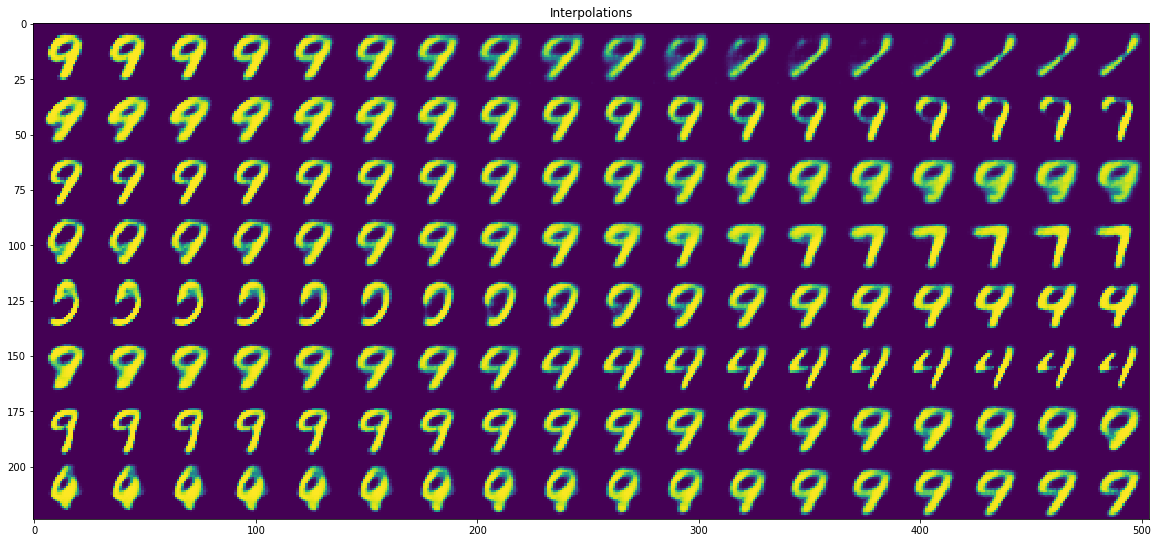

array([3.4111216, 3.1416955, 1.3443363, 3.1039941, 3.617278 , 2.0826502,
       2.8963013, 1.7895306], dtype=float32)

In [19]:
# plot reconstructions
plot_64(model=model,sample=True)

# sample model and plot interpolations
z_in = model.sample(batch_size=10,z_out=True)
plot_interpolation_m1(model, z_in=z_in,image_n=0,latent_dim=latent_dim,imsize=28,interpolate_dim=18,std_=3,batch_size=10)


## M2

In [20]:
epochs = 2
train_loss = []
train_acc = []
test_loss = []
test_acc = []

In [21]:
# define model and optimizer
mode = "m2"
model = M2(device, image_channels=image_channels, h_dim=1024, z_dim=latent_dim, num_labels=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


### 2.4.2 (Report) 
Train the model for the same number of epochs as the VAE earlier. Report the
accuracy.

Epoch 1 of 2
	 Training ...


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


	 Testing ...
Train Loss: 468.2456
Val Loss: 390.4684
Train Acc: 0.2172
Val Acc: 0.3324
Epoch 2 of 2
	 Training ...
	 Testing ...
Train Loss: 364.5972
Val Loss: 328.8667
Train Acc: 0.6201
Val Acc: 0.7559


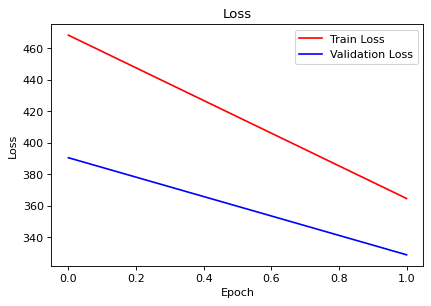

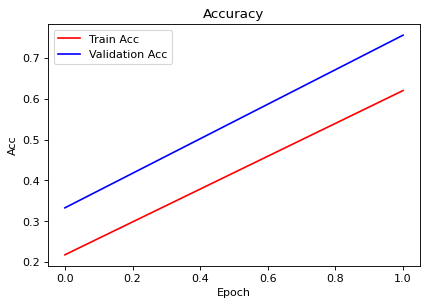

In [22]:
# train network
train_loss, test_loss, train_acc, test_acc = run_epochs(mode, model, optimizer, epochs, train_loader, test_loader, train_loss, test_loss, train_acc, test_acc)

# plot loss
plot_loss_m2(train_loss, test_loss, train_acc, test_acc)

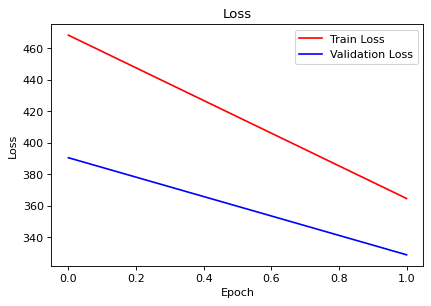

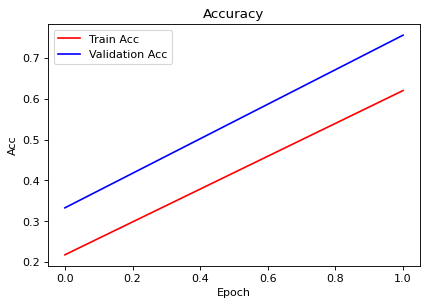

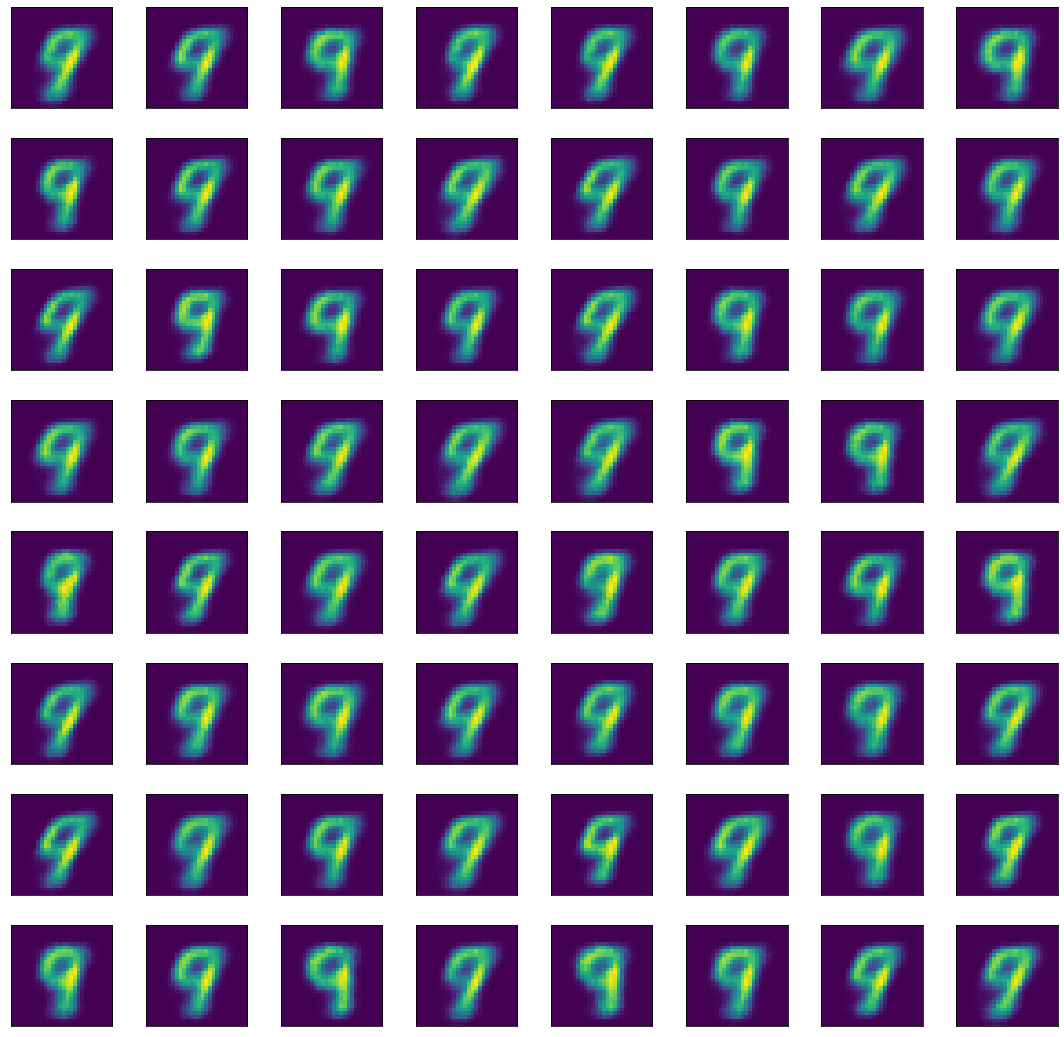

In [23]:
# plot loss
plot_loss_m2(train_loss,test_loss, train_acc, test_acc)

# plot reconstructions
plot_64_m2(model=model, sample=True, y=(torch.ones(64).type(torch.int64)*9))

In [28]:
def make_cm(model, dset):
    loader = torch.utils.data.DataLoader(dset, batch_size=batch_size,
                                              sampler=stratified_sampler(dset.targets, classes))

    acc_running = 0.
    cm = np.zeros(shape=(len(classes), len(classes)), dtype=np.int16)

    model.eval()
    with torch.no_grad():
        for idx, (images, labels) in enumerate(loader):
            X = images.type(torch.float)
            y_test = labels.numpy()

            y_pred = model.classifier(X.to(model.device)).cpu().numpy()
            y_pred = np.argmax(y_pred, axis=1)

            test_acc_batch = sklearn.metrics.accuracy_score(y_test, y_pred)
            acc_running += test_acc_batch

            cm_batch = sklearn.metrics.confusion_matrix(
                y_true=y_test, y_pred=y_pred)
            cm += cm_batch

    acc = acc_running / len(loader)
    print("Mean acc: ", acc)

    df_cm = pd.DataFrame(cm, index=[str(i) for i in classes],
                         columns=[str(i) for i in classes])

    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

Mean acc (train):  0.6201108213820078
Mean acc (val):  0.7559065934065934
Mean acc:  0.7655918961864406


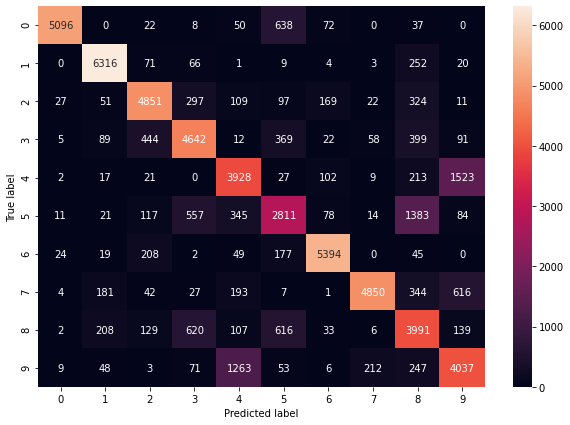

Mean acc:  0.7647977941176471


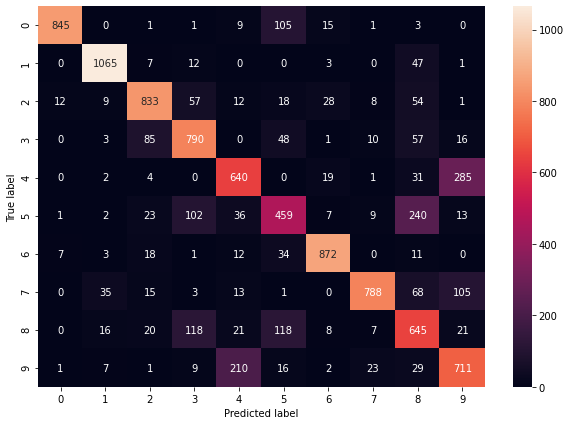

In [29]:
# confusion_matrixes
print("Mean acc (train): ", train_acc[-1])
print("Mean acc (val): ", test_acc[-1])
make_cm(model, dset_train)
make_cm(model, dset_test)

### Sample and interpolations

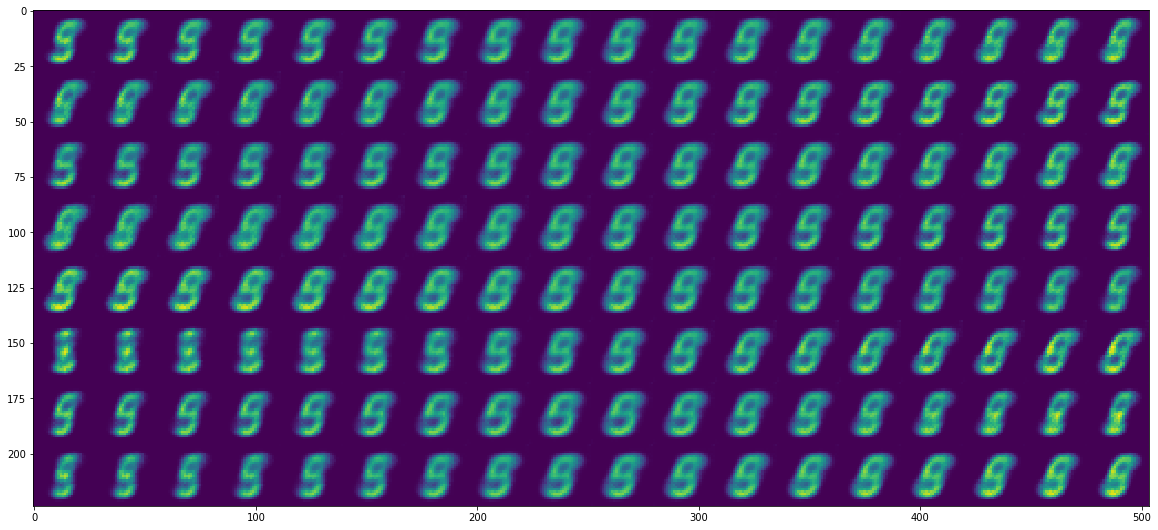

array([2.8850377, 2.6842082, 2.0621624, 2.149756 , 2.3174222, 2.7549806,
       3.223626 , 2.6815333], dtype=float32)

In [30]:
# sample model and plot interpolations
z_in = model.sample(y=torch.Tensor([0,1,2,3,4,5,6,7,8,9]).type(torch.int64))["z"]
plot_interpolation_m2(model, z_in=z_in,image_n=0,latent_dim=latent_dim,imsize=28,interpolate_dim=18,std_=5,batch_size=10000)
